In [ ]:
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

from pathlib import Path
import random
import decimal

import pandas as pd
import numpy as np
import math

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import binom
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
#from scipy.stats import distributions as dist

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Regressão Linear Simples

Ao invés de utilizar o Teste-T, podemos realizar teste de hipóteses através de regressão linear, conforme mostrado neste vídeo e no exemplo abaixo.
https://www.youtube.com/watch?v=p_d-JcPrLOU

In [ ]:
# set seed for reproducibility
np.random.seed(42)

# test parameters
n_obs = 1000 # sample size for each variant
mean = 100 # mean of control group population
std = 40 # standard deviation of the population distributions
effect = 0 # true difference between variant and control population means
alpha = 0.05 # nível de significância

# sample from the control and variant distributions
control_sample = stats.norm(loc=mean, scale=std).rvs(size=n_obs)
variant_sample = stats.norm(loc=mean + effect, scale=std).rvs(size=n_obs)

df = pd.DataFrame(columns=('variant','values'))
df = df.append(pd.DataFrame({'variant': 0, 'values': control_sample}), ignore_index=True)
df = df.append(pd.DataFrame({'variant': 1, 'values': variant_sample}), ignore_index=True)

# Test 1: Frequentist T-Test for proportions
t_stat, p_value = ttest_ind(variant_sample, control_sample, equal_var=False, alternative='two-sided')
impact = (variant_sample.mean() - control_sample.mean())


# Test 2: Simple Linear Regression
model_summary = smf.ols(f'values ~ variant', data=df).fit(alpha=alpha).summary()
p_value_2 = float(model_summary.tables[1].data[2][4])
impact_2 = float(model_summary.tables[1].data[2][1])
t_stat_2 = float(model_summary.tables[1].data[2][3])
std_error = float(model_summary.tables[1].data[2][2])

print('# TESTE 1: Frequentist T-Test for proportions \n')
print(f"P-value: {round(p_value,3)} / T-statistic: {round(t_stat,3)} / Impact: {round(impact,4)}")
print('\n# TESTE 2: Linear Regression \n')
print(f"P-value: {p_value_2} / T-statistic: {t_stat_2} / Impact: {impact_2}\n")
print("Linear Regression Summary:\n")
print(model_summary)


# TESTE 1: Frequentist T-Test for proportions 

P-value: 0.244 / T-statistic: 1.165 / Impact: 2.0602

# TESTE 2: Linear Regression 

P-value: 0.244 / T-statistic: 1.165 / Impact: 2.0602

Linear Regression Summary:

                            OLS Regression Results                            
Dep. Variable:                 values   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.358
Date:                Wed, 13 Mar 2024   Prob (F-statistic):              0.244
Time:                        00:07:25   Log-Likelihood:                -10191.
No. Observations:                2000   AIC:                         2.039e+04
Df Residuals:                    1998   BIC:                         2.040e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                     

# Estratificação e Regressão Linear Múltipla

Referências:
- https://www.tripadvisor.com/engineering/reducing-a-b-test-measurement-variance-by-30/?utm_source=pocket_reader

Se nós tivermos conhecimento de alguma covariante em nossa amostra (subgrupos com grande diferença nas médias da métrica de sucessso; ex: PRI x PRO, tráfego quente x frio, etc) podemos incluir ela em nosso modelo de regressão, reduzindo a variância e aumentando o poder do teste.

**Exemplo**

Na nossa população de interesse, conseguimos identificar que os usuários estão separados em dois subgrupos distintos (Grupo 0 e Grupo 1), sendo a média desses grupos bastante diferente (Grupo 0 tem média 80 e Grupo 1 tem média 120).

In [ ]:
# Set seed for reproducibility
np.random.seed(42)


# sample from control and variant populations, from the distributions of each subgroup
group_1 = stats.norm(loc=80, scale=20).rvs(size=100000)
group_2 = stats.norm(loc=120, scale=20).rvs(size=100000)

# insert samples into a dataframe - from now on this will be our 'population'
df = pd.DataFrame(columns=('group','values'))
df = df.append(pd.DataFrame({'group':0, 'values': group_1}), ignore_index=True)
df = df.append(pd.DataFrame({'group':1, 'values': group_2}), ignore_index=True)


In [ ]:
# Summary statistics for the whole table
total_stats = df['values'].agg(['mean', 'std', 'count']).to_frame().T
total_stats.index = ['Total']

# Summary statistics for each subgroup
group_stats = df.groupby(by='group').agg(mean=('values','mean'),std=('values','std'),count=('values','count'))

# Concatenate total_stats with group_stats
result = pd.concat([group_stats, total_stats])

display(result)

mean        std     count
0       80.019337  20.018119  100000.0
1      120.019621  19.978786  100000.0
Total  100.019479  28.283284  200000.0

<Axes: xlabel='values', ylabel='Count'>

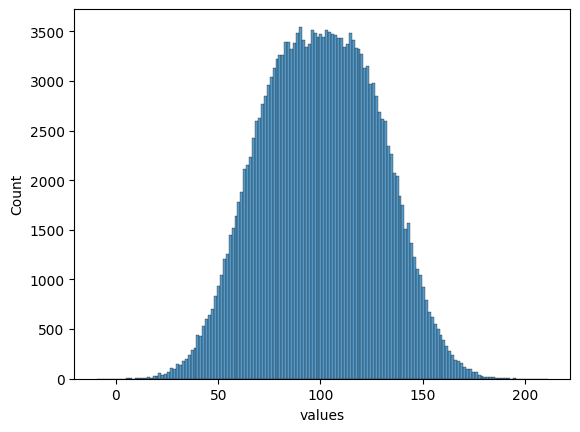

In [ ]:
sns.histplot(data=df, x="values")

<Axes: xlabel='values', ylabel='Count'>

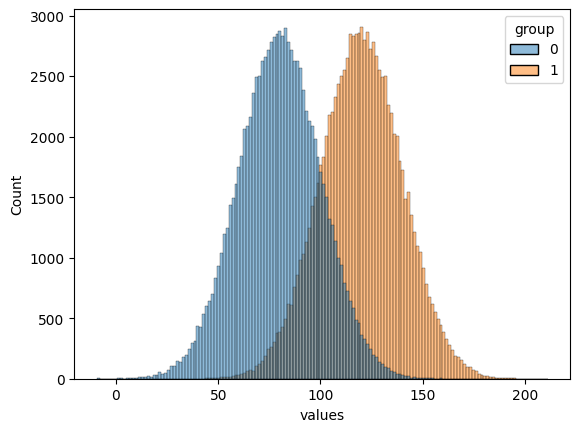

In [ ]:
sns.histplot(data=df, x="values", hue="group")

Agora vamos simular um teste A/B (utilizando a população acima) onde o efeito da nossa mudança é de +2 unidades para todos os usuários na variante.

In [ ]:
# Sample 2000 observations without replacement
df_sample = df.sample(n=2000, replace=False, random_state=42).reset_index()

# Label 1000 observations as 'control' and 1000 as 'variant'
df_sample.loc[:999, 'variant'] = 'control'
df_sample.loc[1000:, 'variant'] = 'variant'

# Add effect value to the variant observations
effect = 2

# Create a new column 'test_values' and assign values based on the condition
df_sample['test_values'] = np.where(df_sample['variant'] == 'variant',
                                    df_sample['values'] + effect,
                                    df_sample['values'])

In [ ]:
# Summary statistics for each variant
df_sample.groupby(by=['variant']).agg(mean=('test_values','mean'),std=('test_values','std'),count=('test_values','count'))

mean        std  count
variant                              
control  101.815047  27.562519   1000
variant  102.398829  28.466185   1000

In [ ]:
# Summary statistics for each group + variant
df_sample.groupby(by=['variant','group']).agg(mean=('test_values','mean'),std=('test_values','std'),count=('test_values','count'))

mean        std  count
variant group                              
control 0       80.679727  19.687727    460
        1      119.819209  19.286801    540
variant 0       81.912470  20.560469    491
        1      122.160719  19.718744    509

**Teste de Hipótese**

Abaixo comparamos um teste T padrão com um modelo onde o subgrupo é inserido como covariante em uma regressão linear.
Comparando os dois modelos, a regressão múltipla gerou uma redução de 50% na variância da estimativa de impacto, que também se aproximou muito mais do valor real.


In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# parametros do teste
alpha = 0.05

df_sample['variant'] = df_sample['variant'].replace({'control': 0, 'variant': 1})

variant_sample = df_sample.query("variant == 1")['test_values']
control_sample = df_sample.query("variant == 0")['test_values']

# Test 1: Frequentist T-Test for proportions
t_stat, p_value = ttest_ind(variant_sample, control_sample, equal_var=False, alternative='two-sided')
impact = (variant_sample.mean() - control_sample.mean())
se = impact/t_stat

# Test 2: Multiple Linear Regression
model_summary_2 = smf.ols(f'test_values ~ variant + group', data=df_sample).fit(alpha=alpha).summary()
p_value_2 = float(model_summary_2.tables[1].data[3][4])
impact_2 = float(model_summary_2.tables[1].data[3][1])
t_stat_2 = float(model_summary_2.tables[1].data[3][3])
std_error_2 = float(model_summary_2.tables[1].data[3][2])

print('# TESTE 1: Frequentist T-Test for proportions \n')
print(f"P-value: {round(p_value,3)} / T-statistic: {round(t_stat,3)} / Impact: {round(impact,4)} / SE:{round(se,3)}\n")
print('# TESTE 2: Multiple Linear Regression - "Group" as a model covariate\n')
print(f"P-value: {p_value_2} / T-statistic: {t_stat_2} / Impact: {impact_2} / SE:{std_error_2}\n")
print("\n")
print("Multiple Linear Regression Summary:\n")
print(model_summary_2)

# TESTE 1: Frequentist T-Test for proportions 

P-value: 0.641 / T-statistic: 0.466 / Impact: 0.5838 / SE:1.253

# TESTE 2: Multiple Linear Regression - "Group" as a model covariate

P-value: 0.041 / T-statistic: 2.048 / Impact: 1.8143 / SE:0.886



Multiple Linear Regression Summary:

                            OLS Regression Results                            
Dep. Variable:            test_values   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     1001.
Date:                Wed, 13 Mar 2024   Prob (F-statistic):          6.65e-302
Time:                        00:08:40   Log-Likelihood:                -8808.2
No. Observations:                2000   AIC:                         1.762e+04
Df Residuals:                    1997   BIC:                         1.764e+04
Df Model:                           2                                         
Co

# Poder (Falsos Negativos)

Usando o mesmo exemplo acima, como essa redução de variância se reflete em aumento de Poder do teste (probabilidade de falsos negativos)?

Executando um teste T padrão, com 1.000 usuários por variante teríamos apenas 36% de poder. Realizando a regressão múltipla com covariante esse poder aumentou para 60%.

A adição da covariante no modelo não aumentou nossa taxa de falso positivo na simulação de testes A/A.

In [ ]:
import numpy as np

def cohen_d(mean1, mean2, std):
    """
    Calculate Cohen's d for two groups.

    Parameters:
    - group1: array-like, first group of data
    - group2: array-like, second group of data

    Returns:
    - Cohen's d
    """
    mean_diff = mean1 - mean2
    pooled_std = np.sqrt((std**2 + std**2) / 2)
    return mean_diff / pooled_std

In [ ]:
from statsmodels.stats.power import TTestIndPower

# Initialize the TTestIndPower class
power_analysis = TTestIndPower()

# Define parameters for the power analysis
effect_size = cohen_d(102,100,28)  # Set the effect size you want to detect
alpha = 0.05        # Set the significance level
ratio = 1.0         # Set the ratio of sample sizes (1.0 for equal sample sizes)
sample_size = 1000  # Sample size for each variant

# Perform the power analysis for T-Test
power = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=None, nobs1=sample_size,ratio=ratio, alternative='two-sided')

print("Estimated Power:", round(power,2))


Estimated Power: 0.36


In [ ]:
# Set seed for reproducibility
np.random.seed(42)

# create DataFrame
df_tests = pd.DataFrame(columns = ('test','control', 'variant', 'control_group_0', 'control_group_1', 'variant_group_0', 'variant_group_1','result_t', 'impact_t', 'se_t','result_reg','impact_reg','se_reg', 'aa_result', 'aa_impact', 'aa_se'))

# parametros do teste
n_tests = 1000 # quantos testes AA vamos simular
n_obs = 2000 # tamanho de amostra por variante em cada teste
effect = 2
alpha = 0.05 # nível de significância

for k in range(n_tests):

  # Sample 2000 observations without replacement
  df_sample = df.sample(n=n_obs, replace=False).reset_index()

  # Label 1000 observations as 'control' and 1000 as 'variant'
  df_sample.loc[:999, 'variant'] = 0
  df_sample.loc[1000:, 'variant'] = 1

  # Create a new column 'test_values' and assign values based on the condition
  df_sample['test_values'] = np.where(df_sample['variant'] == 1,
                                      df_sample['values'] + effect,
                                      df_sample['values'])

  variant_sample = df_sample.query("variant == 1")['test_values']
  control_sample = df_sample.query("variant == 0")['test_values']
  variant_g0_sample = df_sample.query("variant == 1 and group==0")['test_values']
  variant_g1_sample = df_sample.query("variant == 1 and group==1")['test_values']
  control_g0_sample = df_sample.query("variant == 0 and group==0")['test_values']
  control_g1_sample = df_sample.query("variant == 0 and group==1")['test_values']

  # Test 1: Frequentist T-Test for proportions
  t_stat, p_value = ttest_ind(variant_sample, control_sample, equal_var=False, alternative='two-sided')
  result_1 = 1 if p_value < alpha else 0
  impact_1 = (variant_sample.mean() - control_sample.mean())
  se_1 = impact_1 / t_stat

  # Test 2: Multiple Linear Regression
  model_summary = smf.ols(f'test_values ~ variant + group', data=df_sample).fit(alpha=alpha).summary()
  p_value_2 = float(model_summary.tables[1].data[3][4])
  result_2 = 1 if p_value_2 < alpha else 0
  impact_2 = float(model_summary.tables[1].data[3][1])
  se_2 = float(model_summary.tables[1].data[3][2])

  # Test 3: A/A Test
  model_summary = smf.ols(f'values ~ variant + group', data=df_sample).fit(alpha=alpha).summary()
  p_value_3 = float(model_summary.tables[1].data[3][4])
  result_3 = 1 if p_value_3 < alpha else 0
  impact_3 = float(model_summary.tables[1].data[3][1])
  se_3 = float(model_summary.tables[1].data[3][2])

  # save results into dataframe
  test = [k+1, control_sample.mean(), variant_sample.mean(), control_g0_sample.mean(), control_g1_sample.mean(), variant_g0_sample.mean(), variant_g1_sample.mean(), result_1, impact_1, se_1, result_2, impact_2, se_2, result_3, impact_3, se_3]
  df_tests.loc[len(df_tests)] = test

In [ ]:
power_t = df_tests['result_t'].mean()
power_reg = df_tests['result_reg'].mean()
false_pos_aa = df_tests['aa_result'].mean()
var_t = df_tests['se_t'].mean()**2
var_reg = df_tests['se_reg'].mean()**2

In [ ]:
print(f"The variance of the impact estimate had a {round(((var_reg/var_t)-1)*100,2)}% reduction")

The variance of the impact estimate had a -49.98% reduction


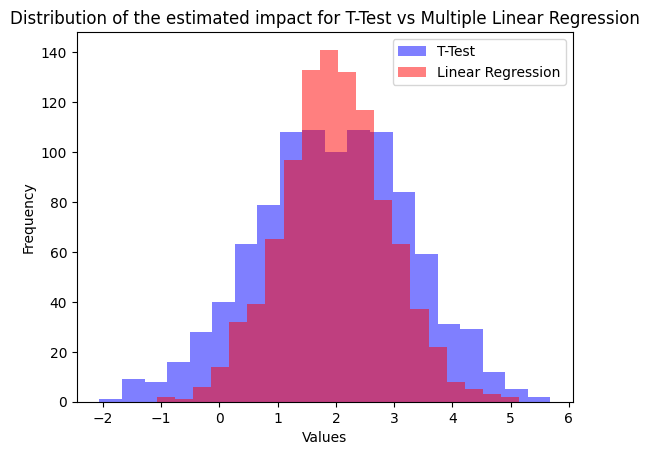

In [ ]:
# Plot histogram for column 'A'
plt.hist(df_tests['impact_t'], bins=20, color='blue', alpha=0.5, label='T-Test')

# Plot histogram for column 'B'
plt.hist(df_tests['impact_reg'], bins=20, color='red', alpha=0.5, label='Linear Regression')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of the estimated impact for T-Test vs Multiple Linear Regression')

# Add legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
print(f"The power of the multiple linear regression of {round(power_reg*100,3)}% is {round(power_reg/power_t,1)} times higher then the standard t-test with power of {round(power_t*100,3)}%")

The power of the multiple linear regression of 59.7% is 1.7 times higher then the standard t-test with power of 36.1%


In [ ]:
print(f"The false positive rate did not increase and remained similar to our alpha level, with {round(false_pos_aa*100,3)}%")

The false positive rate did not increase and remained similar to our alpha level, with 5.6%
